# Reading the Data

In [1]:
import pandas as pd
df_matched = pd.read_excel("del7_ADRD_with_map_3new.xlsx")

In [5]:
print(df_dropped.columns.tolist())


['study_id', 'study_enc_id', 'study_case_id', 'duration', 'del_1', 'year-proc', 'sex', 'race', 'ethnicity', 'age', 'asa_class', 'asa1', 'asa1e', 'asa2', 'asa2e', 'asa3', 'asa3e', 'asa4', 'asa4e', 'asa5', 'asa5e', 'asa6', 'asa6e', 'CCI', 'cisatracurium', 'hydromorphone', 'lorazepam', 'midazolam', 'sufentanil', 'alfentanil', 'dexmedetomidine', 'etomidate', 'fentanyl', 'ketamine', 'methadone', 'meperidine', 'morphine', 'propofol', 'remifentanil', 'rocuronium', 'succinylcholine', 'vecuronium', 'diazepam', 'map_min', 'map_max', 'esmolol', 'hydralazine', 'labetalol', 'metoprolol', 'nicardipine', 'nitroprusside', 'enalapril', 'epinephrine', 'norepinephrine', 'phenylephrine', 'ephedrine', 'vasopressin', 'dopamine', 'milrinone', 'dobutamine', 'SE', 'Anemia', 'CKD', 'COPD', 'Cancer', 'Cancer METS', 'Cardiac arrhythmia', 'Cerebral Vascular Dz', 'Chr Dialysis', 'Chr ETOH', 'Chr heart failure', 'Diabetes', 'Disease of the AORTA', 'Drug Abuse', 'HTN', 'Heart valve dz', 'Hemiplegia/Paraplegia', 'Isch

# Exploratory Data Analysis

In [3]:
df_matched[df_matched["outcome"] != df_matched["del_1"]]

,Unnamed: 0,case_x,study_id,study_enc_id,study_case_id,duration,outcome,del_1,del_8,year-proc,...,GU,ENT,EP/PACEMAKER,GI-NORA,EYE,case_y,Dementia,map_lt_65_min,map_65_95_min,map_gt_95_min


In [4]:
suspects = ['anti-parkinsonian', 'antidepressants', 'Dementia', 'Muscle Relaxants', 'Antimuscarinics/Incontinence Meds']
print("suspects unique values:")
for col in suspects:
    print(f"{col}: {df_matched[col].unique()}")

suspects unique values:
anti-parkinsonian: [0]
antidepressants: [0]
Dementia: [0 1]
Muscle Relaxants: [0 1]
Antimuscarinics/Incontinence Meds: [0]


In [5]:
df_matched['ethnicity'].value_counts()

ethnicity
Not Hispanic or Latino    5544
Hispanic or Latino          98
Unknown                     52
Declined                     5
Name: count, dtype: int64

# Data Preprocessing

In [ ]:
df_dropped = df_matched.drop(columns=['map_mean', 'outcome','Case','Muscle Relaxants', 'case_x', 'case_y', 'del_8', 'Unnamed: 0', 'case', 'Antimuscarinics/Incontinence Meds', 'asa_class.1', 'age.1', 'anti-parkinsonian', 'antidepressants', 'Respiratory Medications', 'study_id_case', 'study_enc_id_case', 'study_case_id_case'], errors="ignore")


## Medication Class Binarization (Presence/Absence Encoding)

In [9]:
mask_cols = [
    'anti histaminics', 'Antispasmotics', 'sedatives',
    'antihypertensives', 'Gastrointestinal Agents',
    'opioids and NSAIDS', 'psychoactive and anticonvulsant ',
    'steroids', 'anti-arrhythmics', 'antibiotics'
]

# Keep originals with suffix "_orig"
for col in mask_cols:
    df_dropped[col + "_orig"] = df_dropped[col]
    df_dropped[col] = (df_dropped[col] > 0).astype(int)   

In [10]:
# Clean column names (strip, lower, replace spaces)
df_dropped.columns = (
    df_dropped.columns
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
)

## Feature Engineering for ASA Class and Emergency Status

In [12]:
# --- Step 1: Drop "_orig" columns ---
df_mod = df_dropped.loc[:, ~df_dropped.columns.str.endswith("_orig")].copy()
print(f"Dropped _orig columns. Remaining columns: {df_mod.shape[1]}")

# --- Step 2: Create ASA numeric and emergency flag ---
# ASA class numeric: extract from asa_class (if present)
if "asa_class" in df_mod.columns:
    # Coerce text to numeric safely
    df_mod["asa_class_num"] = (
        df_mod["asa_class"]
        .astype(str)
        .str.extract(r"(\d)")
        .astype(float)
    )

# Emergency flag: 1 if any of the ASA_emergency variants (asa1e–asa6e) are 1
asa_emerg_cols = [c for c in df_mod.columns if c.lower().startswith("asa") and c.lower().endswith("e")]
df_mod["asa_emerg_flag"] = df_mod[asa_emerg_cols].max(axis=1) if asa_emerg_cols else 0

# --- Step 3: Drop individual ASA one-hot columns (asa1–asa6 and asa1e–asa6e) ---
asa_cols_to_drop = [c for c in df_mod.columns if c.lower().startswith("asa") and (c.lower().endswith(tuple(str(i) for i in range(1, 7))) or c.lower().endswith(tuple(f"{i}e" for i in range(1, 7))))]
df_mod.drop(columns=asa_cols_to_drop, inplace=True, errors="ignore")

print(f"Created asa_class_num + asa_emerg_flag and dropped {len(asa_cols_to_drop)} ASA dummies.")
print(df_mod[["asa_class", "asa_class_num", "asa_emerg_flag"]].head())


Dropped _orig columns. Remaining columns: 113
Created asa_class_num + asa_emerg_flag and dropped 12 ASA dummies.
  asa_class  asa_class_num  asa_emerg_flag
0         3            3.0               0
1         3            3.0               0
2         3            3.0               0
3         3            3.0               0
4         4            4.0               0


In [13]:
print(df_mod[["asa_class", "asa_class_num", "asa_emerg_flag"]].head(20))

   asa_class  asa_class_num  asa_emerg_flag
0          3            3.0               0
1          3            3.0               0
2          3            3.0               0
3          3            3.0               0
4          4            4.0               0
5          3            3.0               0
6          4            4.0               0
7          4            4.0               0
8         3E            3.0               1
9         4E            4.0               1
10         3            3.0               0
11        4E            4.0               1
12        4E            4.0               1
13        5E            5.0               1
14        5E            5.0               1
15        4E            4.0               1
16         3            3.0               0
17        4E            4.0               1
18         3            3.0               0
19         3            3.0               0


## Phik-Based Feature Correlation Screening

In [15]:
# --- 1. Drop redundant column ---
df_phik = df_mod.drop(columns=["asa_class"], errors="ignore").copy()

# --- 2. Import and compute Phik correlation matrix ---
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import numpy as np, pandas as pd

# Numeric columns (for better binning)
interval_cols = df_phik.select_dtypes(include=["number"]).columns.tolist()

# Compute Phik correlation matrix
phik_mat = phik_matrix(df_phik, interval_cols=interval_cols)

# --- 3. Flatten into long-form pairs ---
np.fill_diagonal(phik_mat.values, np.nan)
mask_upper = np.triu(np.ones_like(phik_mat, dtype=bool), k=1)
pairs = (
    phik_mat.where(mask_upper)
            .stack()
            .reset_index()
            .rename(columns={"level_0": "col1", "level_1": "col2", 0: "phik"})
            .sort_values("phik", ascending=False)
)

# --- 4. View highly correlated pairs (>|0.8|) ---
high_pairs = pairs.loc[pairs["phik"] > 0.8].reset_index(drop=True)
print("Highly correlated pairs (>|0.8|):")
print(high_pairs.head(50).to_string(index=False))

# Optional visualization (good for overview)
# plot_correlation_matrix(phik_mat.values, x_labels=phik_mat.columns, y_labels=phik_mat.index, vmin=0.5, vmax=1.0)


Highly correlated pairs (>|0.8|):
         col1                            col2     phik
 study_enc_id                   study_case_id 0.999921
     ketamine psychoactive and anticonvulsant 0.998867
    midazolam                       sedatives 0.996790
study_case_id                       year-proc 0.990390
 study_enc_id                       year-proc 0.990062
     fentanyl              opioids and NSAIDS 0.975181
          CKD                    Chr Dialysis 0.971636
   metoprolol               antihypertensives 0.948791
     Chr ETOH                      Drug Abuse 0.839514


In [16]:
# --- Drop redundant high-correlation features (based on expert review) ---
drop_cols = [
    "psychoactive and anticonvulsant",
    "sedatives",
    "Chr Dialysis",
    "opioids and NSAIDS",
    "antihypertensives",
    "Drug Abuse"
]

df_mod = df_mod.drop(columns=drop_cols, errors="ignore")

print(f"Dropped {len(drop_cols)} highly correlated columns:")
print(drop_cols)
print(f"\nRemaining columns: {df_mod.shape[1]}")


Dropped 6 highly correlated columns:
['psychoactive and anticonvulsant', 'sedatives', 'Chr Dialysis', 'opioids and NSAIDS', 'antihypertensives', 'Drug Abuse']

Remaining columns: 97


In [15]:
unique_names = df_mod['ethnicity'].unique()
print(unique_names)

['Not Hispanic or Latino' 'Unknown' nan 'Hispanic or Latino' 'Declined']


In [19]:
print(df_mod.columns.tolist())


['study_id', 'study_enc_id', 'study_case_id', 'duration', 'del_1', 'year-proc', 'sex', 'race', 'ethnicity', 'age', 'asa_class', 'CCI', 'cisatracurium', 'hydromorphone', 'lorazepam', 'midazolam', 'sufentanil', 'alfentanil', 'dexmedetomidine', 'etomidate', 'fentanyl', 'ketamine', 'methadone', 'meperidine', 'morphine', 'propofol', 'remifentanil', 'rocuronium', 'succinylcholine', 'vecuronium', 'diazepam', 'map_min', 'map_max', 'esmolol', 'hydralazine', 'labetalol', 'metoprolol', 'nicardipine', 'nitroprusside', 'enalapril', 'epinephrine', 'norepinephrine', 'phenylephrine', 'ephedrine', 'vasopressin', 'dopamine', 'milrinone', 'dobutamine', 'SE', 'Anemia', 'CKD', 'COPD', 'Cancer', 'Cancer METS', 'Cardiac arrhythmia', 'Cerebral Vascular Dz', 'Chr ETOH', 'Chr heart failure', 'Diabetes', 'Disease of the AORTA', 'HTN', 'Heart valve dz', 'Hemiplegia/Paraplegia', 'Ischemic heart dz', 'LIVER DZ', 'Obesity', 'Peripheral vascular disease', 'Psychiatric Disorders', 'Pulmonaru Vasular Dz', 'Resp Failure

## Missing values check and imputation

In [17]:
# --- Missing value summary for df_dropped ---
import pandas as pd

missing_summary = (
    df_mod.isna()
    .sum()
    .to_frame("n_missing")
    .assign(pct_missing=lambda d: 100 * d["n_missing"] / len(df_mod))
    .query("n_missing > 0")  # only columns with missing values
    .sort_values("pct_missing", ascending=False)
)

print("=== Missing value summary (only columns with >0 missing) ===")
display(missing_summary.head(30))  # show top 30 for quick scan
print(f"\nTotal columns with missing values: {missing_summary.shape[0]}")
print(f"Total rows: {len(df_mod)}")


=== Missing value summary (only columns with >0 missing) ===


,n_missing,pct_missing
ethnicity,30,0.523652
asa_class,1,0.017455
asa_class_num,1,0.017455



Total columns with missing values: 3
Total rows: 5729


In [18]:
# --- Handle missing values in df_mod ---
df_mod = df_mod.copy()

# 1) Fill missing ethnicity with 'Unknown'
df_mod["ethnicity"] = df_mod["ethnicity"].fillna("Unknown")

# 2) Impute ASA class and ASA class_num
if "asa_class" in df_mod.columns:
    mode_asa = df_mod["asa_class"].mode(dropna=True)[0]
    df_mod["asa_class"] = df_mod["asa_class"].fillna(mode_asa)

if "asa_class_num" in df_mod.columns:
    median_asa_num = df_mod["asa_class_num"].median()
    df_mod["asa_class_num"] = df_mod["asa_class_num"].fillna(median_asa_num)

# --- Quick verification ---
print("Remaining missing values after imputation:")
print(df_mod.isna().sum().loc[lambda x: x > 0])


Remaining missing values after imputation:
Series([], dtype: int64)


# Feature Schema Definition for Reproducible Modeling

In [20]:
# --- Build & save feature schema from df_mod (final) ---
import json, numpy as np, pandas as pd
from pathlib import Path

TARGET = "del_1"

# Exclude IDs & admin columns from features, but keep them in df_mod for CV grouping
ID_COLS = ["study_id", "study_enc_id", "study_case_id"]
ADMIN_COLS = ["year-proc", "asa_class"]  # asa_class_num stays as continuous; raw asa_class is redundant
EXCLUDE = [TARGET] + ID_COLS + ADMIN_COLS

df = df_mod.copy()

# 1) Constants (<=1 unique non-null)
constant_cols = (
    df.drop(columns=EXCLUDE, errors="ignore")
      .nunique(dropna=True)
      .pipe(lambda s: s[s <= 1].index.tolist())
)

# 2) Split by dtype
num_like = df.select_dtypes(include=[np.number, "boolean", "bool"]) \
             .drop(columns=EXCLUDE + constant_cols, errors="ignore")
obj_like = df.select_dtypes(include=["object", "category"]) \
             .drop(columns=EXCLUDE + constant_cols, errors="ignore")

# 3) Detect strict 0/1 binaries among numerics
def is_binary(series: pd.Series) -> bool:
    vals = pd.Series(series).dropna().unique()
    return len(vals) > 0 and set(vals).issubset({0, 1})

binary_cols = [c for c in num_like.columns if is_binary(num_like[c])]
continuous_cols = sorted(set(num_like.columns) - set(binary_cols))
categorical_cols = sorted(obj_like.columns.tolist())

# 4) Enforce ASA design explicitly (keep numeric; flag emergency as binary)
if "asa_class_num" in df.columns:
    if "asa_class_num" in binary_cols:   binary_cols.remove("asa_class_num")
    if "asa_class_num" not in continuous_cols and "asa_class_num" not in constant_cols:
        continuous_cols.append("asa_class_num")

if "asa_emerg_flag" in df.columns and is_binary(df["asa_emerg_flag"]):
    if "asa_emerg_flag" in continuous_cols: continuous_cols.remove("asa_emerg_flag")
    if "asa_emerg_flag" not in binary_cols and "asa_emerg_flag" not in constant_cols:
        binary_cols.append("asa_emerg_flag")

# 5) Final feature list (exclude target, IDs, admin, constants)
feature_list = [c for c in df.columns if c not in set(EXCLUDE + constant_cols)]

# Ensure mutual exclusivity across buckets (priority: categorical > binary > continuous)
seen = set(); final_cats, final_bins, final_conts = [], [], []
for c in sorted(categorical_cols):
    if c in feature_list and c not in seen: final_cats.append(c); seen.add(c)
for c in sorted(binary_cols):
    if c in feature_list and c not in seen: final_bins.append(c); seen.add(c)
for c in sorted(continuous_cols):
    if c in feature_list and c not in seen: final_conts.append(c); seen.add(c)

# Ordered feature list (optional; your choice)
feature_list = final_conts + final_cats + final_bins

# 6) Label stats
label_stats = {TARGET: float(pd.Series(df[TARGET]).mean())}

# 7) Save schema
schema = {
    "target": TARGET,
    "aux_outcomes": [],
    "binary_cols": sorted(final_bins),
    "continuous_cols": sorted(final_conts),
    "categorical_cols": sorted(final_cats),
    "constant_cols": sorted(constant_cols),
    "feature_list": feature_list,
    "dtypes": {c: str(df[c].dtype) for c in feature_list},
    "label_stats": label_stats,
    "exclude_cols": EXCLUDE,        # helpful breadcrumb
    "id_cols": ID_COLS,             # for grouping later
}

Path("artifacts").mkdir(exist_ok=True)
with open("artifacts/feature_schema.json", "w") as f:
    json.dump(schema, f, indent=2)

print("Saved → artifacts/feature_schema.json")
print(f"Counts → continuous={len(schema['continuous_cols'])}, categorical={len(schema['categorical_cols'])}, binary={len(schema['binary_cols'])}, constants={len(schema['constant_cols'])}")
print("Categoricals:", schema["categorical_cols"])
print("Target prevalence:", f"{schema['label_stats'][TARGET]:.3f}")
print("Excluded (not modeled):", EXCLUDE)


Saved → artifacts/feature_schema.json
Counts → continuous=10, categorical=3, binary=78, constants=0
Categoricals: ['ethnicity', 'race', 'sex']
Target prevalence: 0.500
Excluded (not modeled): ['del_1', 'study_id', 'study_enc_id', 'study_case_id', 'year-proc', 'asa_class']


In [14]:
continuous_cols

['CCI',
 'age',
 'asa_class_num',
 'duration',
 'map_65_95_min',
 'map_gt_95_min',
 'map_lt_65_min',
 'map_max',
 'map_min',
 'total_mac_hrs']

In [20]:
binary_cols

['cisatracurium',
 'hydromorphone',
 'lorazepam',
 'midazolam',
 'sufentanil',
 'alfentanil',
 'dexmedetomidine',
 'etomidate',
 'fentanyl',
 'ketamine',
 'methadone',
 'meperidine',
 'morphine',
 'propofol',
 'remifentanil',
 'rocuronium',
 'succinylcholine',
 'vecuronium',
 'diazepam',
 'esmolol',
 'hydralazine',
 'labetalol',
 'metoprolol',
 'nicardipine',
 'nitroprusside',
 'enalapril',
 'epinephrine',
 'norepinephrine',
 'phenylephrine',
 'ephedrine',
 'vasopressin',
 'dopamine',
 'milrinone',
 'dobutamine',
 'SE',
 'Anemia',
 'CKD',
 'COPD',
 'Cancer',
 'Cancer METS',
 'Cardiac arrhythmia',
 'Cerebral Vascular Dz',
 'Chr ETOH',
 'Chr heart failure',
 'Diabetes',
 'Disease of the AORTA',
 'HTN',
 'Heart valve dz',
 'Hemiplegia/Paraplegia',
 'Ischemic heart dz',
 'LIVER DZ',
 'Obesity',
 'Peripheral vascular disease',
 'Psychiatric Disorders',
 'Pulmonaru Vasular Dz',
 'Resp Failure',
 'Transplanted Organ',
 'anti histaminics',
 'Antispasmotics',
 'Gastrointestinal Agents',
 'stero

In [21]:
categorical_cols

['ethnicity', 'race', 'sex']

# Unfitted Feature Preprocessing for Cross-Validated Modeling

In [21]:
# A) Build & save UNFITTED preprocessor (no leakage, no model)
import json
import joblib
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

# 0) Load schema produced earlier
with open("artifacts/feature_schema.json", "r") as f:
    schema = json.load(f)

TARGET            = schema["target"]
continuous_cols   = schema["continuous_cols"]
categorical_cols  = schema["categorical_cols"]   # <-- fixed spelling
binary_cols       = schema["binary_cols"]
EXCLUDED          = schema.get("exclude_cols", [])
ID_COLS           = schema.get("id_cols", ["study_id", "study_enc_id", "study_case_id"])

# 1) Resolve columns actually present in df_mod (guard against drift)
present_cont = [c for c in continuous_cols  if c in df_mod.columns]
present_cat  = [c for c in categorical_cols if c in df_mod.columns]
present_bin  = [c for c in binary_cols      if c in df_mod.columns]

# Safety: ensure excluded + target are not in any present_* lists
ban = set(EXCLUDED + [TARGET])
present_cont = [c for c in present_cont if c not in ban]
present_cat  = [c for c in present_cat  if c not in ban]
present_bin  = [c for c in present_bin  if c not in ban]

# 2) Define unfitted transformers
try:
    # Newer sklearn (>=1.2)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    # Older sklearn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

cont_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  RobustScaler()),
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe",    ohe),
])

bin_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
])

# 3) ColumnTransformer (UNFITTED) — no fit/transform here
preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipe, present_cont),
        ("cat",  cat_pipe,  present_cat),
        ("bin",  bin_pipe,  present_bin),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 4) Save the unfitted preprocessor and a spec for reproducibility
Path("artifacts").mkdir(exist_ok=True)
joblib.dump(preprocessor, "artifacts/preprocessor_unfitted.joblib")

spec = {
    "target": TARGET,
    "excluded": EXCLUDED,
    "id_cols": ID_COLS,
    "present_cont": present_cont,
    "present_cat": present_cat,
    "present_bin": present_bin,
}
with open("artifacts/preprocessor_spec.json", "w") as f:
    json.dump(spec, f, indent=2)

print("Saved → artifacts/preprocessor_unfitted.joblib")
print("Spec   → artifacts/preprocessor_spec.json")
print(f"Blocks → continuous={len(present_cont)}, categorical={len(present_cat)}, binary={len(present_bin)}")
print("Not modeled (kept only for grouping/metadata):", EXCLUDED)


Saved → artifacts/preprocessor_unfitted.joblib
Spec   → artifacts/preprocessor_spec.json
Blocks → continuous=10, categorical=3, binary=78
Not modeled (kept only for grouping/metadata): ['del_1', 'study_id', 'study_enc_id', 'study_case_id', 'year-proc', 'asa_class']


# Models

## Define 6 domains

In [22]:
# B1) Define 6 domains (split anesthetic-related) and save

import json
from pathlib import Path

import pandas as pd

# ---- Load schema ----
with open("artifacts/feature_schema.json", "r") as f:
    schema = json.load(f)

TARGET = schema["target"]
FEATURES = set(schema["feature_list"])
EXCLUDED = set(schema.get("exclude_cols", []))
ID_COLS = set(schema.get("id_cols", ["study_id", "study_enc_id", "study_case_id"]))

# ---- Clinician-approved groups ----
patient_related = [
    "sex", "race", "ethnicity", "age", "asa_class_num", "asa_emerg_flag", "CCI",
    "Anemia", "CKD", "COPD", "Cancer", "Cancer METS", "Cardiac arrhythmia", "Cerebral Vascular Dz",
    "Chr ETOH", "Chr heart failure", "Diabetes", "Disease of the AORTA", "HTN", "Heart valve dz",
    "Hemiplegia/Paraplegia", "Ischemic heart dz", "LIVER DZ", "Obesity",
    "Peripheral vascular disease", "Psychiatric Disorders", "Pulmonaru Vasular Dz",
    "Resp Failure", "Transplanted Organ",
    "anti histaminics", "Antispasmotics", "Gastrointestinal Agents", "steroids",
    "antipsychotics", "anti-arrhythmics", "antibiotics",
]

surgery_related = [
    "duration", "General Surgery", "Vascular", "Orthopedics", "Thoracic", "Neurosurgery",
    "GYN", "GU", "ENT", "EP/PACEMAKER", "GI-NORA", "EYE",
]

# ---- Anesthetic-related split into 4 subdomains ----
hemodynamics = [
    "map_lt_65_min", "map_65_95_min", "map_gt_95_min", "map_min", "map_max",
]

anesthetics = [
    "total_mac_hrs", "inhal_anesthesia",
    "propofol", "midazolam", "dexmedetomidine", "etomidate", "ketamine",
    "rocuronium", "succinylcholine", "vecuronium", "cisatracurium",
    "sufentanil", "fentanyl", "remifentanil", "morphine", "hydromorphone",
    "meperidine", "methadone", "lorazepam", "diazepam",
]

vasopressors = [
    "epinephrine", "norepinephrine", "phenylephrine", "ephedrine", "vasopressin",
    "dopamine", "dobutamine", "milrinone",
]

antihypertensives = [
    "labetalol", "esmolol", "nicardipine", "nitroprusside", "enalapril", "hydralazine",
]

domains_raw = {
    "patient_related": patient_related,
    "surgery_related": surgery_related,
    "hemodynamics": hemodynamics,
    "anesthetics": anesthetics,
    "vasopressors": vasopressors,
    "antihypertensives": antihypertensives,
}

# ---- Resolve domains to modelable columns (requires df_mod in memory) ----
def resolve_columns(cols, *, df, features, excluded):
    """Keep only columns that exist in df, are in schema feature_list, and are not excluded."""
    df_cols = set(df.columns)
    return [c for c in cols if (c in df_cols) and (c in features) and (c not in excluded)]

if "df_mod" not in globals():
    raise NameError("df_mod must exist in the notebook before running this cell.")

domains = {
    name: resolve_columns(cols, df=df_mod, features=FEATURES, excluded=EXCLUDED)
    for name, cols in domains_raw.items()
}

# ---- Sanity checks ----
for name, cols in domains.items():
    if TARGET in cols:
        raise ValueError(f"Target leaked into domain '{name}'.")
    bad_ids = set(cols) & ID_COLS
    if bad_ids:
        raise ValueError(f"ID columns leaked into domain '{name}': {sorted(bad_ids)}")
    bad_excl = set(cols) & EXCLUDED
    if bad_excl:
        raise ValueError(f"Excluded columns leaked into domain '{name}': {sorted(bad_excl)}")

# ---- Summary + save ----
summary = (
    pd.DataFrame([(k, len(v)) for k, v in domains.items()], columns=["domain", "n_features"])
      .set_index("domain")
      .sort_index()
)

print("Resolved domain feature counts:")
display(summary)

for name, cols in domains.items():
    print(f"\n[{name}] ({len(cols)} features):")
    print(", ".join(cols))

Path("artifacts").mkdir(exist_ok=True)
with open("artifacts/domains.json", "w") as f:
    json.dump(domains, f, indent=2)

print("\nSaved → artifacts/domains.json")

Resolved domain feature counts:


,n_features
domain,
anesthetics,20
antihypertensives,6
hemodynamics,5
patient_related,36
surgery_related,12
vasopressors,8



[patient_related] (36 features):
sex, race, ethnicity, age, asa_class_num, asa_emerg_flag, CCI, Anemia, CKD, COPD, Cancer, Cancer METS, Cardiac arrhythmia, Cerebral Vascular Dz, Chr ETOH, Chr heart failure, Diabetes, Disease of the AORTA, HTN, Heart valve dz, Hemiplegia/Paraplegia, Ischemic heart dz, LIVER DZ, Obesity, Peripheral vascular disease, Psychiatric Disorders, Pulmonaru Vasular Dz, Resp Failure, Transplanted Organ, anti histaminics, Antispasmotics, Gastrointestinal Agents, steroids, antipsychotics, anti-arrhythmics, antibiotics

[surgery_related] (12 features):
duration, General Surgery, Vascular, Orthopedics, Thoracic, Neurosurgery, GYN, GU, ENT, EP/PACEMAKER, GI-NORA, EYE

[hemodynamics] (5 features):
map_lt_65_min, map_65_95_min, map_gt_95_min, map_min, map_max

[anesthetics] (20 features):
total_mac_hrs, inhal_anesthesia, propofol, midazolam, dexmedetomidine, etomidate, ketamine, rocuronium, succinylcholine, vecuronium, cisatracurium, sufentanil, fentanyl, remifentanil, 

In [23]:
# B2) Domain-wise LGBM training with GroupKFold; OOF predictions per domain

import json
from pathlib import Path

import joblib  # optional; kept if you later decide to persist fold models
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# ---- Load schema/spec/domains ----
with open("artifacts/feature_schema.json", "r") as f:
    schema = json.load(f)
with open("artifacts/preprocessor_spec.json", "r") as f:
    spec = json.load(f)
with open("artifacts/domains.json", "r") as f:
    domains = json.load(f)

TARGET = schema["target"]
EXCLUDED = set(schema.get("exclude_cols", []))
ID_COLS = schema.get("id_cols", ["study_id", "study_enc_id", "study_case_id"])

present_cont = spec["present_cont"]
present_cat = spec["present_cat"]
present_bin = spec["present_bin"]

if "df_mod" not in globals():
    raise NameError("df_mod must exist in the notebook before running this cell.")

# ---- Preprocessor factory (restricted to a column subset) ----
def make_preprocessor(cols_subset):
    cont = [c for c in present_cont if c in cols_subset]
    cat = [c for c in present_cat if c in cols_subset]
    biny = [c for c in present_bin if c in cols_subset]

    # Backward-compatible OneHotEncoder signature
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    cont_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", RobustScaler()),
        ]
    )
    cat_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]
    )
    bin_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ("cont", cont_pipe, cont),
            ("cat", cat_pipe, cat),
            ("bin", bin_pipe, biny),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

# ---- Data matrices ----
# Drop target + excluded (IDs can be kept in X as long as you never select them; domains should exclude them anyway)
X_cols = [c for c in df_mod.columns if c not in (EXCLUDED | {TARGET})]
X = df_mod[X_cols].copy()
y = df_mod[TARGET].astype(int).to_numpy()

# GroupKFold grouping (patient/study level)
if "study_id" not in df_mod.columns:
    raise KeyError("df_mod must contain 'study_id' for GroupKFold grouping.")
groups = df_mod["study_id"].to_numpy()

# ---- CV setup ----
cv = GroupKFold(n_splits=5)

# Storage for out-of-fold predictions per domain
oof = pd.DataFrame(index=df_mod.index, columns=list(domains.keys()), dtype=float)

# Base LGBM params (no early stopping to keep the pipeline simple)
lgbm_params = dict(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=600,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=40,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    n_jobs=-1,
    verbosity=-1,
)

metrics = {d: {"auc": [], "prauc": [], "brier": []} for d in domains}

# ---- Train/evaluate per fold, per domain ----
for fold_num, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups), start=1):
    X_tr, X_va = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_va = y[train_idx], y[valid_idx]

    print(f"\n=== Fold {fold_num} ===")

    for dname, dcols in domains.items():
        dcols_present = [c for c in dcols if c in X_tr.columns]
        if not dcols_present:
            raise ValueError(f"Domain '{dname}' has no usable columns in this dataset.")

        prep = make_preprocessor(dcols_present)
        clf = LGBMClassifier(**lgbm_params)
        pipe = Pipeline(steps=[("prep", prep), ("clf", clf)])

        pipe.fit(X_tr[dcols_present], y_tr)
        p_va = pipe.predict_proba(X_va[dcols_present])[:, 1]

        oof.loc[X_va.index, dname] = p_va

        auc = roc_auc_score(y_va, p_va)
        prauc = average_precision_score(y_va, p_va)
        brier = brier_score_loss(y_va, p_va)

        metrics[dname]["auc"].append(auc)
        metrics[dname]["prauc"].append(prauc)
        metrics[dname]["brier"].append(brier)

        print(f"[{dname}] AUC={auc:.3f} PR-AUC={prauc:.3f} Brier={brier:.3f}")

# ---- Summarize OOF metrics ----
print("\n=== OOF summary per domain ===")
for dname in domains:
    aucs = np.asarray(metrics[dname]["auc"])
    praucs = np.asarray(metrics[dname]["prauc"])
    briers = np.asarray(metrics[dname]["brier"])
    print(
        f"{dname:18s} "
        f"AUC {aucs.mean():.3f} ± {aucs.std():.3f}  "
        f"PR {praucs.mean():.3f} ± {praucs.std():.3f}  "
        f"Brier {briers.mean():.3f} ± {briers.std():.3f}"
    )

# ---- Save OOF predictions for meta-learner ----
Path("artifacts").mkdir(exist_ok=True)
oof.to_parquet("artifacts/oof_domain_preds.parquet", index=True)
print("\nSaved → artifacts/oof_domain_preds.parquet")


=== Fold 1 ===


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[patient_related] AUC=0.745 PR-AUC=0.746 Brier=0.208


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[surgery_related] AUC=0.886 PR-AUC=0.873 Brier=0.135


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hemodynamics] AUC=0.627 PR-AUC=0.640 Brier=0.247


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[anesthetics] AUC=0.693 PR-AUC=0.706 Brier=0.223
[vasopressors] AUC=0.617 PR-AUC=0.617 Brier=0.237
[antihypertensives] AUC=0.519 PR-AUC=0.533 Brier=0.249

=== Fold 2 ===


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[patient_related] AUC=0.753 PR-AUC=0.745 Brier=0.203


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[surgery_related] AUC=0.879 PR-AUC=0.862 Brier=0.139


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hemodynamics] AUC=0.653 PR-AUC=0.632 Brier=0.240


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[anesthetics] AUC=0.683 PR-AUC=0.695 Brier=0.227
[vasopressors] AUC=0.661 PR-AUC=0.646 Brier=0.225
[antihypertensives] AUC=0.526 PR-AUC=0.518 Brier=0.248

=== Fold 3 ===


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[patient_related] AUC=0.756 PR-AUC=0.739 Brier=0.202


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[surgery_related] AUC=0.890 PR-AUC=0.875 Brier=0.136


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hemodynamics] AUC=0.633 PR-AUC=0.611 Brier=0.247


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[anesthetics] AUC=0.679 PR-AUC=0.673 Brier=0.231
[vasopressors] AUC=0.638 PR-AUC=0.619 Brier=0.232
[antihypertensives] AUC=0.504 PR-AUC=0.507 Brier=0.251

=== Fold 4 ===


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[patient_related] AUC=0.738 PR-AUC=0.740 Brier=0.213


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[surgery_related] AUC=0.882 PR-AUC=0.878 Brier=0.140


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hemodynamics] AUC=0.655 PR-AUC=0.678 Brier=0.236


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[anesthetics] AUC=0.688 PR-AUC=0.721 Brier=0.226
[vasopressors] AUC=0.642 PR-AUC=0.648 Brier=0.229
[antihypertensives] AUC=0.533 PR-AUC=0.551 Brier=0.248

=== Fold 5 ===


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[patient_related] AUC=0.738 PR-AUC=0.718 Brier=0.212


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[surgery_related] AUC=0.889 PR-AUC=0.862 Brier=0.135


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hemodynamics] AUC=0.659 PR-AUC=0.620 Brier=0.237
[anesthetics] AUC=0.714 PR-AUC=0.693 Brier=0.215
[vasopressors] AUC=0.635 PR-AUC=0.596 Brier=0.233
[antihypertensives] AUC=0.535 PR-AUC=0.507 Brier=0.247

=== OOF summary per domain ===
patient_related    AUC 0.746 ± 0.007  PR 0.738 ± 0.010  Brier 0.208 ± 0.004
surgery_related    AUC 0.885 ± 0.004  PR 0.870 ± 0.007  Brier 0.137 ± 0.002
hemodynamics       AUC 0.645 ± 0.013  PR 0.636 ± 0.023  Brier 0.241 ± 0.005
anesthetics        AUC 0.691 ± 0.012  PR 0.698 ± 0.016  Brier 0.224 ± 0.005
vasopressors       AUC 0.639 ± 0.014  PR 0.625 ± 0.020  Brier 0.231 ± 0.004
antihypertensives  AUC 0.523 ± 0.011  PR 0.523 ± 0.017  Brier 0.248 ± 0.001

Saved → artifacts/oof_domain_preds.parquet


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Step C1: XGBoost with the same preprocessor and patient-level grouped CV, using light, nested tuning (no leakage).

In [24]:
# B3) Meta-learner (Logistic Regression) over domain OOF predictions (dynamic columns)

import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
from sklearn.model_selection import GroupKFold

# ---- Load target + OOF domain predictions ----
with open("artifacts/feature_schema.json", "r") as f:
    schema = json.load(f)

TARGET = schema["target"]

if "df_mod" not in globals():
    raise NameError("df_mod must exist in the notebook before running this cell.")
if "study_id" not in df_mod.columns:
    raise KeyError("df_mod must contain 'study_id' for GroupKFold grouping.")

y = df_mod[TARGET].astype(int).to_numpy()
groups = df_mod["study_id"].to_numpy()

oof = pd.read_parquet("artifacts/oof_domain_preds.parquet")
meta_feats = oof.columns.tolist()
print(f"Meta-features (domains): {', '.join(meta_feats)}")

# ---- CV on the meta layer ----
cv = GroupKFold(n_splits=5)

oof_meta = np.zeros(len(df_mod), dtype=float)
fold_coefs = []
fold_intercepts = []

for fold, (tr_idx, va_idx) in enumerate(cv.split(oof, y, groups), start=1):
    X_tr = oof.iloc[tr_idx].to_numpy()
    X_va = oof.iloc[va_idx].to_numpy()
    y_tr, y_va = y[tr_idx], y[va_idx]

    meta = LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=200,
        n_jobs=-1,
    )
    meta.fit(X_tr, y_tr)

    p_va = meta.predict_proba(X_va)[:, 1]
    oof_meta[va_idx] = p_va

    auc = roc_auc_score(y_va, p_va)
    pr = average_precision_score(y_va, p_va)
    brier = brier_score_loss(y_va, p_va)
    print(f"[Fold {fold}] STACK AUC={auc:.3f} PR-AUC={pr:.3f} Brier={brier:.3f}")

    fold_coefs.append(meta.coef_.ravel())
    fold_intercepts.append(float(meta.intercept_[0]))

# ---- OOF summary ----
auc_all = roc_auc_score(y, oof_meta)
pr_all = average_precision_score(y, oof_meta)
brier_all = brier_score_loss(y, oof_meta)

print("\n=== OOF performance — META (Logistic on domain probabilities) ===")
print(f"ROC-AUC={auc_all:.3f} PR-AUC={pr_all:.3f} Brier={brier_all:.3f}")

# ---- Coefficient summary ----
fold_coefs_arr = np.vstack(fold_coefs)
coef_mean = fold_coefs_arr.mean(axis=0)
coef_std = fold_coefs_arr.std(axis=0)

w = (
    pd.Series(coef_mean, index=meta_feats, name="weight")
      .sort_values(ascending=False)
)
print("\nMeta-learner (logistic) raw weights (mean across folds):")
display(w.to_frame())

contrib = (
    pd.Series(softmax(coef_mean), index=meta_feats, name="contribution")
      .sort_values(ascending=False)
)
print("\nNormalized (softmax) contribution (mean):")
display(contrib.to_frame())

# ---- Fit final meta on ALL data + save artifacts ----
final_meta = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=200,
    n_jobs=-1,
)
final_meta.fit(oof.to_numpy(), y)

Path("artifacts").mkdir(exist_ok=True)
joblib.dump(final_meta, "artifacts/meta_learner_lr.joblib")

(
    pd.Series(oof_meta, index=df_mod.index, name="meta_oof_prob")
      .to_frame()
      .to_parquet("artifacts/oof_meta_probs.parquet", index=True)
)

print("\nSaved → artifacts/meta_learner_lr.joblib")
print("Saved → artifacts/oof_meta_probs.parquet")

Meta-features (domains): patient_related, surgery_related, hemodynamics, anesthetics, vasopressors, antihypertensives
[Fold 1] STACK AUC=0.900 PR-AUC=0.889 Brier=0.124
[Fold 2] STACK AUC=0.907 PR-AUC=0.892 Brier=0.123
[Fold 3] STACK AUC=0.914 PR-AUC=0.899 Brier=0.118
[Fold 4] STACK AUC=0.904 PR-AUC=0.900 Brier=0.127
[Fold 5] STACK AUC=0.907 PR-AUC=0.880 Brier=0.121

=== OOF performance — META (Logistic on domain probabilities) ===
ROC-AUC=0.905 PR-AUC=0.890 Brier=0.123

Meta-learner (logistic) raw weights (mean across folds):


,weight
surgery_related,6.513403
patient_related,2.475737
anesthetics,0.973380
vasopressors,0.870369
antihypertensives,-0.224672
hemodynamics,-0.350437



Normalized (softmax) contribution (mean):


,contribution
surgery_related,0.973390
patient_related,0.017169
anesthetics,0.003822
vasopressors,0.003448
antihypertensives,0.001153
hemodynamics,0.001017



Saved → artifacts/meta_learner_lr.joblib
Saved → artifacts/oof_meta_probs.parquet



==================== patient_related ====================
[patient_related] Top 15 SHAP features:


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean_abs_shap
2,asa_class_num,0.741589
36,Psychiatric Disorders,0.245640
1,age,0.206879
38,Resp Failure,0.205829
0,CCI,0.200771
29,HTN,0.132904
44,asa_emerg_flag,0.110083
17,Antispasmotics,0.073270
14,sex_F,0.069711
23,Cerebral Vascular Dz,0.063193


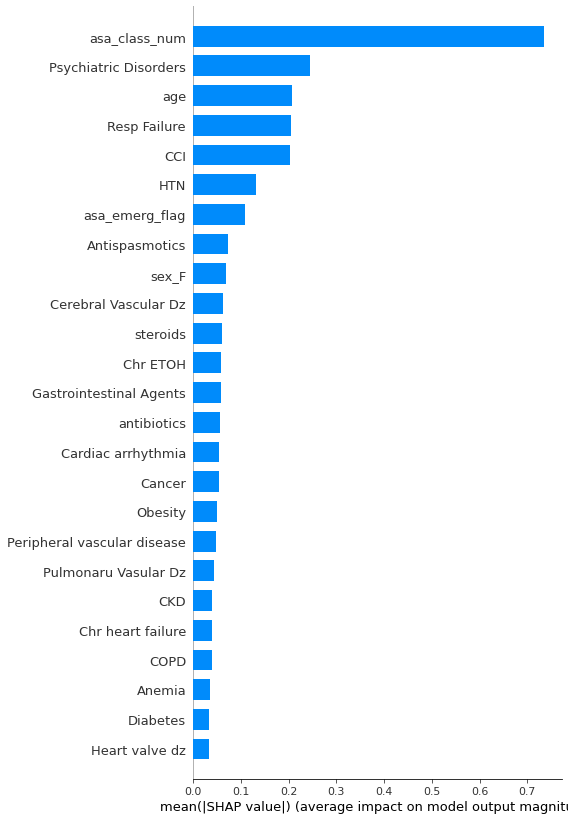

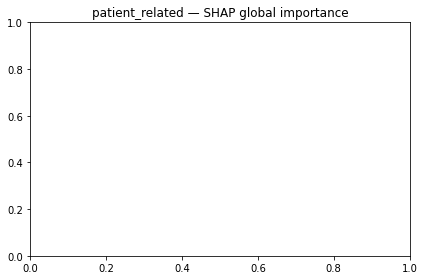

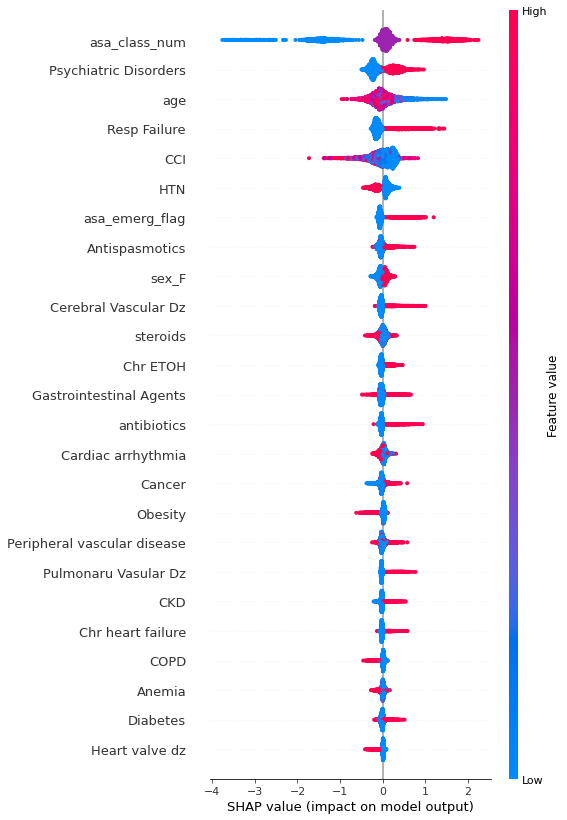

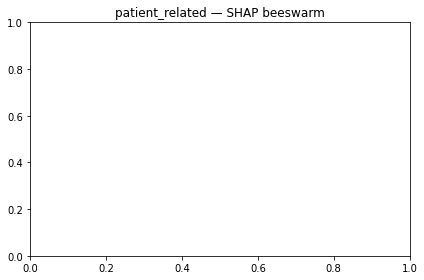


==================== surgery_related ====================
[surgery_related] Top 15 SHAP features:


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean_abs_shap
0,duration,1.449710
3,EYE,0.259927
8,Neurosurgery,0.122463
10,Thoracic,0.109526
9,Orthopedics,0.093695
5,GU,0.069329
1,ENT,0.045246
11,Vascular,0.036431
6,GYN,0.032994
7,General Surgery,0.027178


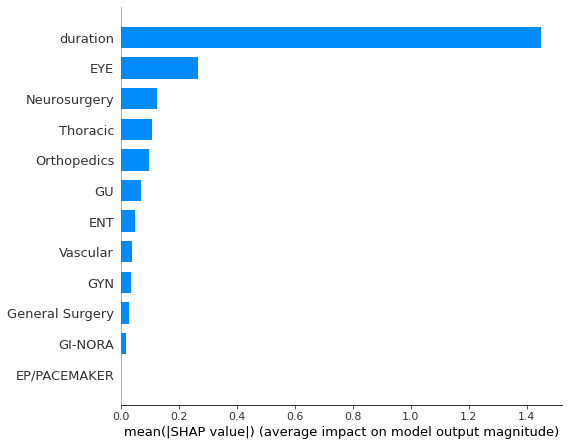

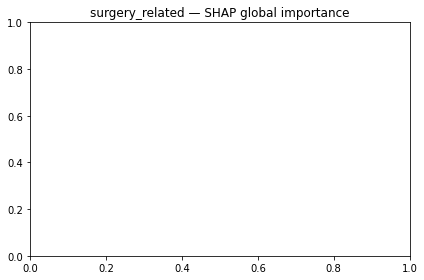

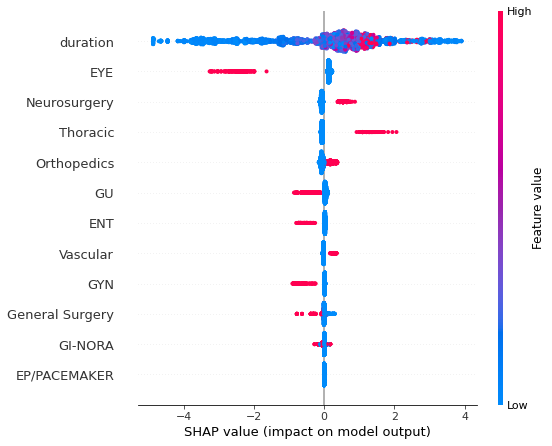

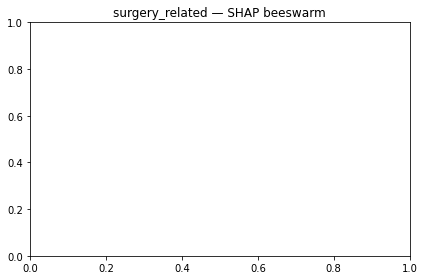


==================== hemodynamics ====================
[hemodynamics] Top 15 SHAP features:


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean_abs_shap
0,map_65_95_min,0.422872
4,map_min,0.390756
3,map_max,0.203263
1,map_gt_95_min,0.192636
2,map_lt_65_min,0.154303


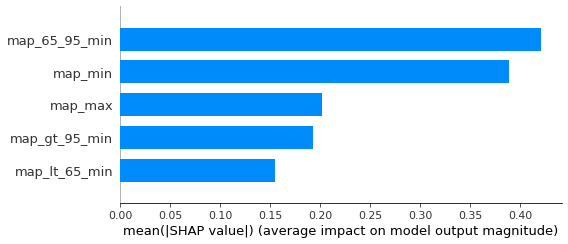

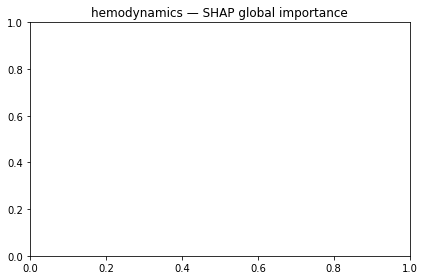

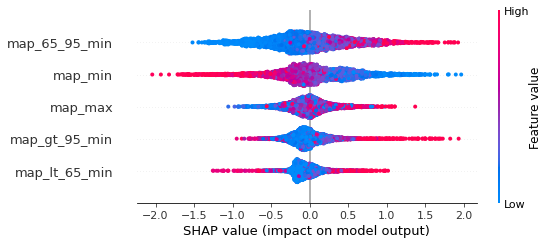

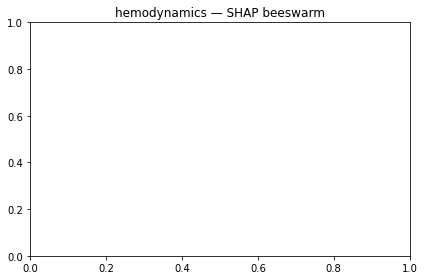


==================== anesthetics ====================
[anesthetics] Top 15 SHAP features:


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean_abs_shap
16,rocuronium,0.458966
0,total_mac_hrs,0.306772
14,propofol,0.262229
17,succinylcholine,0.128586
12,midazolam,0.089289
5,fentanyl,0.081688
1,cisatracurium,0.071687
6,hydromorphone,0.052506
8,ketamine,0.046821
4,etomidate,0.041980


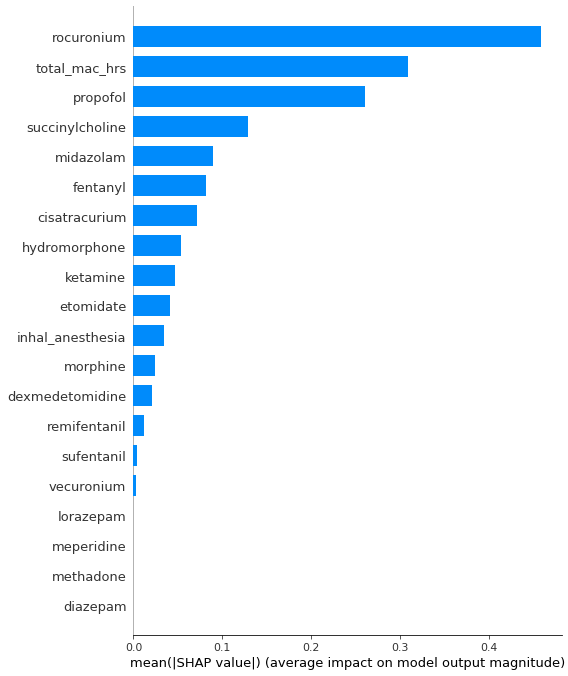

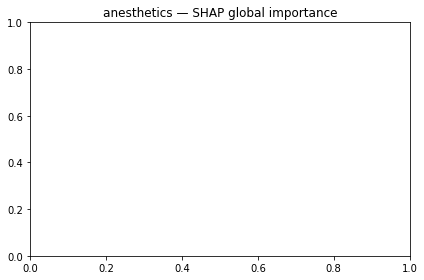

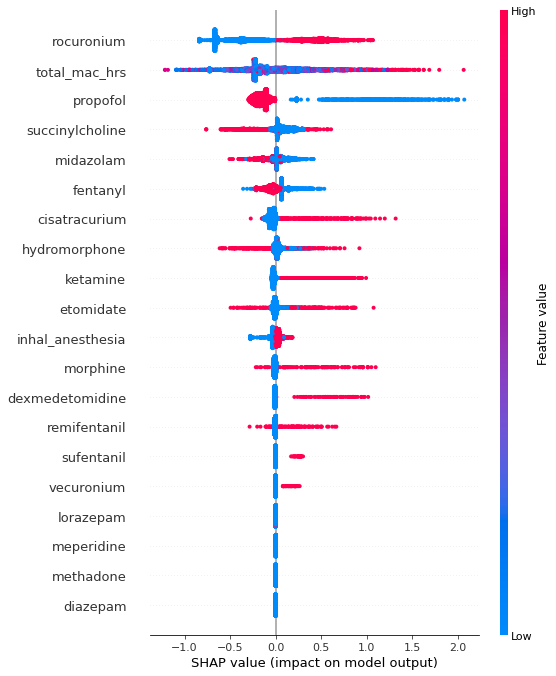

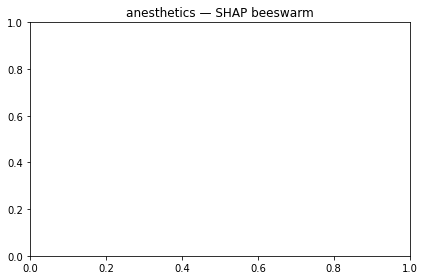


==================== vasopressors ====================
[vasopressors] Top 15 SHAP features:


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean_abs_shap
6,phenylephrine,0.406317
5,norepinephrine,0.106127
7,vasopressin,0.065726
2,ephedrine,0.032245
3,epinephrine,0.028142
1,dopamine,0.000000
0,dobutamine,0.000000
4,milrinone,0.000000


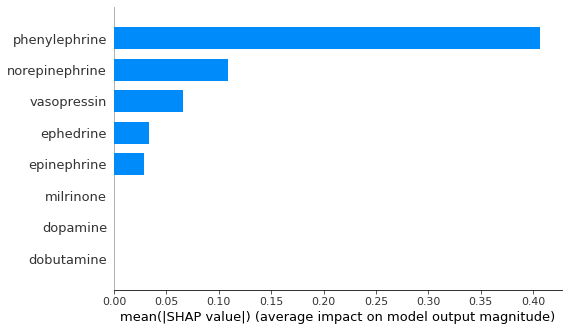

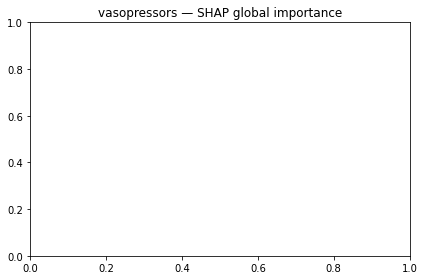

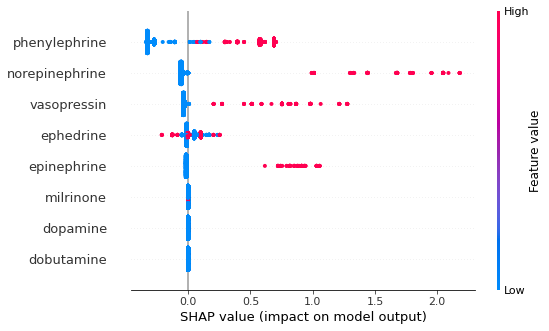

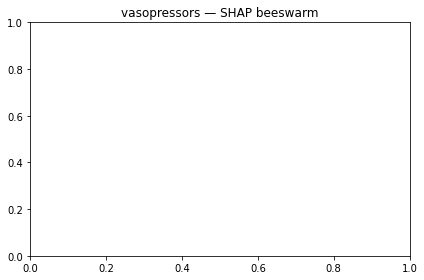


==================== antihypertensives ====================
[antihypertensives] Top 15 SHAP features:


/home/jupyter-shikshuk/.local/lib/python3.9/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,feature,mean_abs_shap
1,esmolol,0.053440
4,nicardipine,0.035547
3,labetalol,0.016847
2,hydralazine,0.003176
0,enalapril,0.000000
5,nitroprusside,0.000000


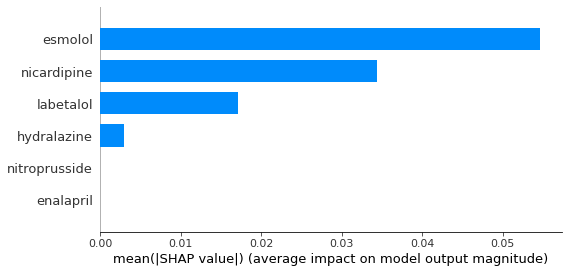

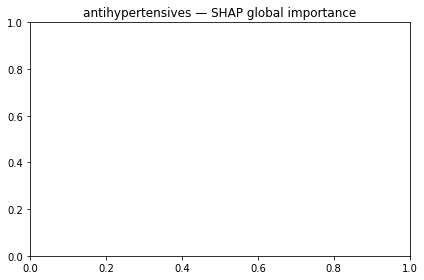

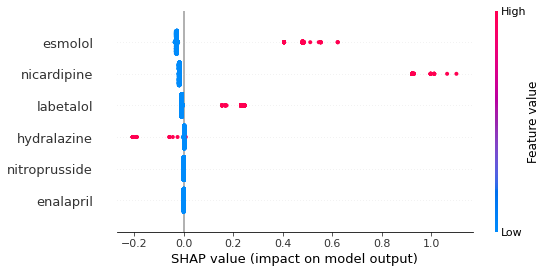

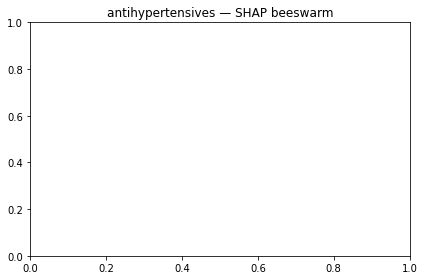


Saved SHAP artifacts to artifacts/shap/ (CSVs + PNGs + pipelines).


In [28]:
# E) Per-domain feature-level SHAP (global only: bar + beeswarm)

import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# ---- Load schema/spec/domains ----
with open("artifacts/feature_schema.json", "r") as f:
    schema = json.load(f)
with open("artifacts/preprocessor_spec.json", "r") as f:
    spec = json.load(f)
with open("artifacts/domains.json", "r") as f:
    domains = json.load(f)

TARGET = schema["target"]
EXCLUDED = set(schema.get("exclude_cols", []))

present_cont = spec["present_cont"]
present_cat = spec["present_cat"]
present_bin = spec["present_bin"]

if "df_mod" not in globals():
    raise NameError("df_mod must exist in the notebook before running this cell.")

# ---- Helper: build preprocessor restricted to chosen columns ----
def make_preprocessor(cols_subset):
    cont = [c for c in present_cont if c in cols_subset]
    cat = [c for c in present_cat if c in cols_subset]
    biny = [c for c in present_bin if c in cols_subset]

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    cont_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", RobustScaler()),
        ]
    )
    cat_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]
    )
    bin_pipe = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ("cont", cont_pipe, cont),
            ("cat", cat_pipe, cat),
            ("bin", bin_pipe, biny),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

# ---- Base LGBM params (same as training) ----
lgbm_params = dict(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=600,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=40,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    n_jobs=-1,
    verbosity=-1,
)

# ---- Data ----
X_cols = [c for c in df_mod.columns if c not in (EXCLUDED | {TARGET})]
y = df_mod[TARGET].astype(int).to_numpy()

domains_to_explain = list(domains.keys())

outdir = Path("artifacts/shap")
outdir.mkdir(parents=True, exist_ok=True)

rng = np.random.RandomState(42)

for dname in domains_to_explain:
    dcols = [c for c in domains[dname] if c in X_cols]
    if not dcols:
        print(f"[{dname}] No usable columns. Skipping.")
        continue

    print(f"\n==================== {dname} ====================")

    # ---- Fit domain pipeline on ALL data (global explanation) ----
    prep = make_preprocessor(dcols)
    clf = LGBMClassifier(**lgbm_params)
    pipe = Pipeline(steps=[("prep", prep), ("clf", clf)])
    pipe.fit(df_mod[dcols], y)

    # ---- Transform features + names after preprocessing ----
    X_trans = pipe.named_steps["prep"].transform(df_mod[dcols])
    feat_names = pipe.named_steps["prep"].get_feature_names_out()

    # ---- Tree SHAP ----
    explainer = shap.TreeExplainer(pipe.named_steps["clf"])
    sv = explainer.shap_values(X_trans)

    # LightGBM binary can return list([class0, class1]) depending on shap version
    if isinstance(sv, list) and len(sv) == 2:
        sv = sv[1]

    # ---- Global importance (mean |SHAP|) ----
    mean_abs = np.abs(sv).mean(axis=0)
    shap_imp = (
        pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
          .sort_values("mean_abs_shap", ascending=False)
    )
    shap_imp.to_csv(outdir / f"{dname}_global_importance.csv", index=False)

    print(f"[{dname}] Top 15 SHAP features:")
    display(shap_imp.head(15))

    # ---- Prepare plotting matrices (sample to keep RAM reasonable) ----
    n = X_trans.shape[0]
    idx = rng.choice(n, size=min(4000, n), replace=False)

    if hasattr(X_trans, "toarray"):
        X_plot = X_trans[idx].toarray()
    else:
        X_plot = X_trans[idx]
    sv_plot = sv[idx]

    # ---- Global plots (DISPLAY + SAVE) ----

    # Bar plot
    plt.figure(figsize=(8, 5))
    shap.summary_plot(
        sv_plot,
        X_plot,
        feature_names=feat_names,
        plot_type="bar",
        max_display=25,
        show=True,  # show inline
    )
    plt.title(f"{dname} — SHAP global importance")
    plt.tight_layout()
    plt.savefig(outdir / f"{dname}_bar.png", dpi=200)
    plt.show()
    plt.close()

    # Beeswarm plot
    plt.figure(figsize=(9, 6))
    shap.summary_plot(
        sv_plot,
        X_plot,
        feature_names=feat_names,
        max_display=25,
        show=True,  # show inline
    )
    plt.title(f"{dname} — SHAP beeswarm")
    plt.tight_layout()
    plt.savefig(outdir / f"{dname}_beeswarm.png", dpi=200)
    plt.show()
    plt.close()

    # ---- Save fitted domain pipeline (optional for reuse) ----
    joblib.dump(pipe, outdir / f"{dname}_pipeline.joblib")

print("\nSaved SHAP artifacts to artifacts/shap/ (CSVs + PNGs + pipelines).")

Sample prevalence of delirium: 0.500


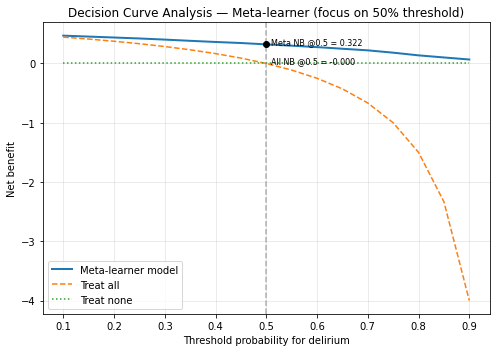

DCA plot saved → artifacts/plots/dca_meta_learner_50pct.png


In [26]:
# =========================
# D3) Decision Curve Analysis (DCA) for meta-learner (focus on 50% threshold)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# True labels and meta-learner OOF probabilities
y = df_mod["del_1"].astype(int).values
meta_oof = pd.read_parquet("artifacts/oof_meta_probs.parquet")["meta_oof_prob"].values
N = len(y)
prevalence = y.mean()
print(f"Sample prevalence of delirium: {prevalence:.3f}")
# Decision thresholds (include 0.5 explicitly)
thresholds = np.linspace(0.1, 0.9, 17)  # 0.1, 0.15, ..., 0.9
if 0.5 not in thresholds:
    thresholds = np.sort(np.append(thresholds, 0.5))
nb_none = np.zeros_like(thresholds)  # net benefit of treating none is 0
nb_all = []
nb_meta = []
for p_t in thresholds:
    # Model
    preds = (meta_oof >= p_t).astype(int)
    TP = np.sum((preds == 1) & (y == 1))
    FP = np.sum((preds == 1) & (y == 0))
    tp_rate = TP / N
    fp_rate = FP / N
    w = p_t / (1 - p_t)  # odds at threshold
    nb_m = tp_rate - w * fp_rate
    nb_meta.append(nb_m)
    # Treat all
    TP_all = np.sum(y == 1)
    FP_all = np.sum(y == 0)
    tp_all = TP_all / N
    fp_all = FP_all / N
    nb_a = tp_all - w * fp_all
    nb_all.append(nb_a)
nb_all = np.array(nb_all)
nb_meta = np.array(nb_meta)
# Plot DCA
os.makedirs("artifacts/plots", exist_ok=True)
plt.figure(figsize=(7,5))
plt.plot(thresholds, nb_meta, label="Meta-learner model", linewidth=2)
plt.plot(thresholds, nb_all, label="Treat all", linestyle="--")
plt.plot(thresholds, nb_none, label="Treat none", linestyle=":")
# Highlight threshold = 0.5
t_star = 0.5
if t_star >= thresholds.min() and t_star <= thresholds.max():
    # interpolate net benefit at 0.5 for model and all
    nb_meta_star = np.interp(t_star, thresholds, nb_meta)
    nb_all_star  = np.interp(t_star, thresholds, nb_all)
    plt.axvline(t_star, color="grey", linestyle="--", alpha=0.6)
    plt.scatter([t_star], [nb_meta_star], color="black", zorder=5)
    plt.text(t_star+0.01, nb_meta_star, f"Meta NB @0.5 = {nb_meta_star:.3f}", fontsize=8)
    plt.text(t_star+0.01, nb_all_star,  f"All NB @0.5 = {nb_all_star:.3f}", fontsize=8)
plt.xlabel("Threshold probability for delirium")
plt.ylabel("Net benefit")
plt.title("Decision Curve Analysis — Meta-learner (focus on 50% threshold)")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
fname = "artifacts/plots/dca_meta_learner_50pct.png"
plt.savefig(fname, dpi=200)
plt.show()
print(f"DCA plot saved → {fname}")

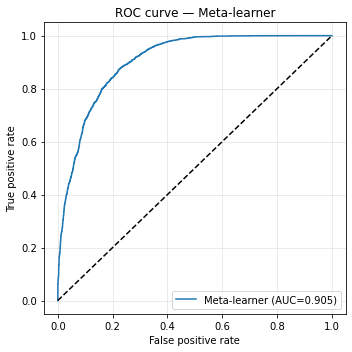

Saved ROC plot → artifacts/plots/roc_meta_learner.png


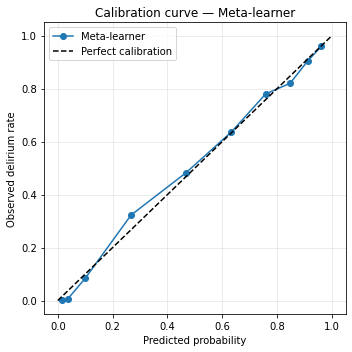

Saved calibration plot → artifacts/plots/calibration_meta_learner.png


In [27]:
# =========================
# D2) Calibration + ROC for META-LEARNER
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score
# Load true labels
y = df_mod["del_1"].astype(int).values
# Load meta-learner OOF probabilities
meta_oof = pd.read_parquet("artifacts/oof_meta_probs.parquet")["meta_oof_prob"].values
# Make output folder
plot_dir = "artifacts/plots"
os.makedirs(plot_dir, exist_ok=True)
# -----------------------
# ROC curve
# -----------------------
fpr, tpr, _ = roc_curve(y, meta_oof)
auc_val = roc_auc_score(y, meta_oof)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"Meta-learner (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve — Meta-learner")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
fname = os.path.join(plot_dir, "roc_meta_learner.png")
plt.savefig(fname, dpi=200)
plt.show()
print(f"Saved ROC plot → {fname}")
# -----------------------
# Calibration curve
# -----------------------
frac_pos, mean_pred = calibration_curve(y, meta_oof, n_bins=10, strategy="quantile")
plt.figure(figsize=(5,5))
plt.plot(mean_pred, frac_pos, "o-", label="Meta-learner")
plt.plot([0,1],[0,1],"k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed delirium rate")
plt.title("Calibration curve — Meta-learner")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
fname = os.path.join(plot_dir, "calibration_meta_learner.png")
plt.savefig(fname, dpi=200)
plt.show()
print(f"Saved calibration plot → {fname}")

In [ ]:
# End of Notebook